In [7]:
from stock_env.envs.single_stock_env import SingleStockEnv
import numpy as np
import pandas as pd
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.dqn import DQN
import matplotlib.pyplot as plt

In [ ]:
price = np.load('price.pkl.npy')
df = pd.DataFrame()
df['A'] = price
env = SingleStockEnv(
    df=df,
    init_cash=5e4,
)
check_env(env)

model = DQN.load("log/dqn_single_stock", env=env)

In [ ]:
done = False
obs = env.reset()
while not done:
    action, _ = model.predict(obs, deterministic=True)
    print(action)
    obs, _, done, _ = env.step(action)

data = pd.concat([df, pd.DataFrame(env.history)], axis=1, join='inner')

In [19]:
data = pd.read_csv('history.csv', index_col=0)

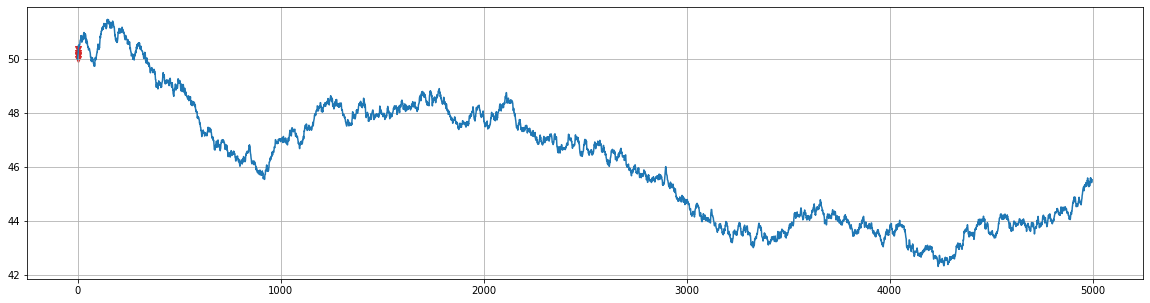

In [34]:
buy = data[data['delta_shares'] > 0]
sell = data[data['delta_shares'] < 0]

fig, axs = plt.subplots(figsize=(20, 5))
axs.grid(True)
axs.plot(data.index, data['A'])
axs.scatter(buy.index, buy['A'], c='tab:green', marker='^')
axs.scatter(sell.index, sell['A'], c='tab:red', marker='v');